In [2]:
%load_ext autoreload

import os
import sys
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../m2py/networks/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as PhysLoss
import network_utils as nuts

torch.manual_seed(28)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# This notebook seeks to use all OFET processing conditions and morphological descriptors to predict device performance. 

## There will be 3 Neural Networks outlined, each with similar architecture, but varying inputs. This first NN will only use processing conditions to try to predict performance

### Inputs:
- DataFrame containing device processing conditions and their subsequent performance. 

*_Note:_* This DataFrame will only contain devices with reasonable performance values.

### Outputs:
- Tensor of predicted performance for given processing conditions

In [3]:
#Take in data as a dataframe for easy preprocessing
device_df = pd.read_excel('/Users/wesleytatum/Desktop/OFET_device_df.xlsx')
print (device_df.shape)
device_df.head()

(80, 15)


,Unnamed: 0,Unnamed: 0.1,Sample,Temperature,Time,Substrate,Device,mu_lin_avg,mu_lin_SD,r_lin_avg,r_lin_sd,on_off_avg,on_off_sd,Vt_avg,Vt_sd
0,0,0,75C-5min_1-IdVg-2-Vd-20,75,5,1,2,0.002176,0.000014,0.580171,0.013437,1119.582374,30.715757,-31.511376,0.198134
1,1,1,75C-5min_1-IdVg-4-Vd-20,75,5,1,4,0.004906,0.000259,0.551756,0.020972,892.258038,4.484375,-28.971871,0.461514
2,2,2,75C-5min_2-IdVg-1-Vd-20,75,5,2,1,0.004643,0.000015,0.557327,0.002400,20.595284,0.172757,-18.556867,0.166910
3,3,3,75C-5min_2-IdVg-3-Vd-20,75,5,2,3,0.012977,0.002372,0.581325,0.004444,619.347250,1024.656122,-21.054614,1.348128
4,4,4,75C-5min_2-IdVg-4-Vd-20,75,5,2,4,0.010087,0.000050,0.585769,0.006963,1812.113114,15.685197,-19.170370,0.165707


In [4]:
# Hyper parameters
num_epochs = 50
batch_size = int(len(device_df['mu_lin_avg'])*0.8*0.9) # 90% of x_train samples
learning_rate = 0.008

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
X = device_df[['Time', 'Temperature']] #input features used to make prediction
Y = device_df[['mu_lin_avg', 'r_lin_avg', 'on_off_avg', 'Vt_avg']] #target features to be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

In [6]:
%autoreload

x_train, x_train_key = nuts.df_Gaussian_normalize(x_train)
y_train, y_train_key = nuts.df_Gaussian_normalize(y_train)

x_test, x_test_key = nuts.df_Gaussian_normalize(x_test)
y_test, y_test_key = nuts.df_Gaussian_normalize(y_test)

# print(f"x_train max = {x_train.max()}")
# print(f"x_train min = {x_train.min()}")
print(f"y_train max = {y_train.max()}")
print(f"y_train min = {y_train.min()}")
# print(f"x_test max = {x_test.max()}")
# print(f"x_test min = {x_test.min()}")
print(f"y_test max = {y_test.max()}")
print(f"y_test min = {y_test.min()}")


print(x_train_key)
print(y_train_key)
print(x_test_key)
print(y_test_key)

print(y_train['on_off_avg'])

mu_train = y_train['mu_lin_avg']
mu_test = y_test['mu_lin_avg']
r_train = y_train['r_lin_avg']
r_test = y_test['r_lin_avg']
on_off_train = y_train['on_off_avg']
on_off_test = y_test['on_off_avg']
vt_train = y_train['Vt_avg']
vt_test = y_test['Vt_avg']

x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
mu_train_tensor = torch.tensor(mu_train.values.astype(np.float32))
r_train_tensor = torch.tensor(r_train.values.astype(np.float32))
on_off_train_tensor = torch.tensor(on_off_train.values.astype(np.float32))
vt_train_tensor = torch.tensor(vt_train.values.astype(np.float32))
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, mu_train_tensor,
                                              r_train_tensor, on_off_train_tensor,
                                              vt_train_tensor) #create tensor with features and targets
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True) #create iterable dataset with batches

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
mu_test_tensor = torch.tensor(mu_test.values.astype(np.float32))
r_test_tensor = torch.tensor(r_test.values.astype(np.float32))
on_off_test_tensor = torch.tensor(on_off_test.values.astype(np.float32))
vt_test_tensor = torch.tensor(vt_test.values.astype(np.float32))
test_tensor = torch.utils.data.TensorDataset(x_test_tensor, mu_test_tensor,
                                              r_test_tensor, on_off_test_tensor,
                                              vt_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = True)

y_train max = mu_lin_avg    2.975655
r_lin_avg     1.658449
on_off_avg    5.765085
Vt_avg        5.988274
dtype: float64
y_train min = mu_lin_avg   -1.284296
r_lin_avg    -2.362938
on_off_avg   -0.342023
Vt_avg       -0.941845
dtype: float64
y_test max = mu_lin_avg    2.212194
r_lin_avg     1.088294
on_off_avg    3.749902
Vt_avg        1.908987
dtype: float64
y_test min = mu_lin_avg   -1.079568
r_lin_avg    -2.267051
on_off_avg   -0.252781
Vt_avg       -0.948302
dtype: float64
{'Time': [14.0625, 8.585471301001329], 'Temperature': [112.5, 26.72612419124244]}
{'mu_lin_avg': [0.017159080343691242, 0.012417407739927224], 'r_lin_avg': [0.7511373265403078, 0.08437863092255235], 'on_off_avg': [14720.24107835738, 43034.27955781191], 'Vt_avg': [-9.014767472910854, 25.42177258298765]}
{'Time': [18.125, 10.1447851956888], 'Temperature': [114.0625, 32.874445495957296]}
{'mu_lin_avg': [0.016605574031702885, 0.012665599912577563], 'r_lin_avg': [0.7357000175734829, 0.110720167473819], 'on_off_avg': [

Now that the data, model, training, and evaluating are all set up, let's actually use everything

In [7]:
# Instantiate our beautiful NN model
# takes in 2 features (anneal time, anneal temp) 
# predicts 4 metrics (mu_lin, r_lin, on_off, Vt)
in_dims = int(x_train_tensor.size(1)) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

model = net.OFET_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)

#define the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

In [8]:
%autoreload

#empty list to hold loss per epoch
train_epoch_losses = []
mu_train_epoch_losses = []
r_train_epoch_losses = []
on_off_train_epoch_losses = []
vt_train_epoch_losses = []

test_epoch_losses = []
mu_test_epoch_losses = []
r_test_epoch_losses = []
on_off_test_epoch_losses = []
vt_test_epoch_losses = []

mu_test_epoch_accuracies = []
r_test_epoch_accuracies = []
on_off_test_epoch_accuracies = []
vt_test_epoch_accuracies = []

save_epochs = np.arange(0, num_epochs, 5)

for epoch in range(num_epochs):
    print('On epoch ', epoch)
    
    save_dir = "/Users/wesleytatum/Desktop/model_states/OFET_NN1/"
    model_name = "OFET_NN1"
    model_path = save_dir+model_name+'*.pt'
    if epoch < 10:
        save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
    else:
        save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'
        
#     if glob.glob(model_path) != []:
#         model_states = glob.glob(model_path)
#         model_states = sorted(model_states)
#         previous_model = model_states[-1]
        
#         model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)
    
    model, train_loss, mu_train_loss, r_train_loss, on_off_train_loss, vt_train_loss = train.train_OFET_df_model(model = model,
                                                                                                                 training_data_set = training_data_set,
                                                                                                                 optimizer = optimizer)
    train_epoch_losses.append(train_loss)
    mu_train_epoch_losses.append(mu_train_loss)
    r_train_epoch_losses.append(r_train_loss)
    on_off_train_epoch_losses.append(on_off_train_loss)
    vt_train_epoch_losses.append(vt_train_loss)
    
    test_loss, mu_test_loss, r_test_loss, on_off_test_loss, vt_test_loss, mu_acc, r_acc, on_off_acc, vt_acc = test.eval_OFET_df_model(model = model,
                                                                                                                                      testing_data_set = testing_data_set)
    test_epoch_losses.append(test_loss)
    mu_test_epoch_losses.append(mu_test_loss)
    r_test_epoch_losses.append(r_test_loss)
    on_off_test_epoch_losses.append(on_off_test_loss)
    vt_test_epoch_losses.append(vt_test_loss)
    
    mu_test_epoch_accuracies.append(mu_acc)
    r_test_epoch_accuracies.append(r_acc)
    on_off_test_epoch_accuracies.append(on_off_acc)
    vt_test_epoch_accuracies.append(vt_acc)
    
    if epoch in save_epochs:
 
        nuts.save_trained_model(save_path, epoch, model, optimizer, train_loss, test_loss)
        #TODO: update for branched OPV specific function?

On epoch  0
Total Epoch Testing Loss = 0.16849741339683533
Total Epoch Testing Accuracy: mu = 18.48614737391472
                              r = 383.7196646258235
                              on_off = -77.82550975680351
                              Vt = -2.0787248853594065
On epoch  1
Total Epoch Testing Loss = 0.05164862424135208
Total Epoch Testing Accuracy: mu = 1.421455293893814
                              r = 309.0744161978364
                              on_off = -147.0905650407076
                              Vt = -13.875990849919617
On epoch  2
Total Epoch Testing Loss = 0.33172062039375305
Total Epoch Testing Accuracy: mu = 9.073060192167759
                              r = 294.8176635429263
                              on_off = -179.71884608268738
                              Vt = -13.650287210475653
On epoch  3
Total Epoch Testing Loss = 0.44814950227737427
Total Epoch Testing Accuracy: mu = 30.694507877342403
                              r = 231.03603231720626
  

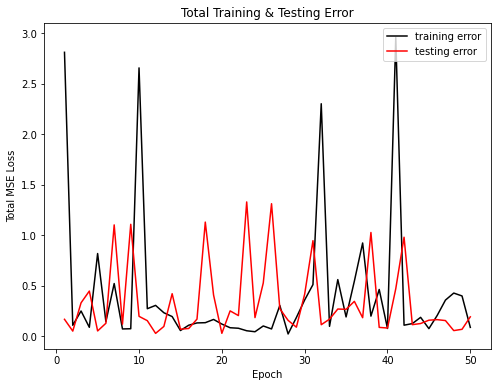

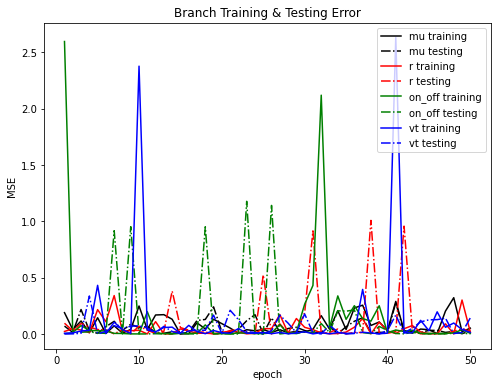

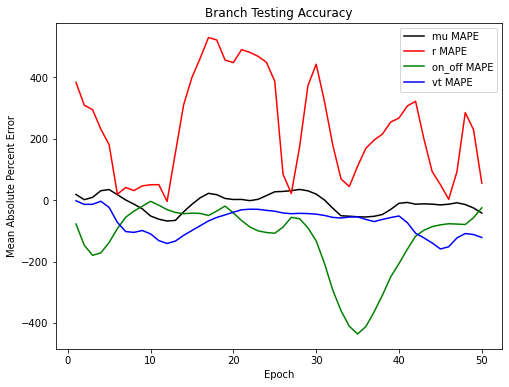

In [9]:
epochs = np.arange(1, (num_epochs+1), 1)

nuts.plot_OFET_df_loss(epochs, train_epoch_losses, test_epoch_losses,
                       mu_train_epoch_losses, mu_test_epoch_losses,
                       r_train_epoch_losses, r_test_epoch_losses,
                       on_off_train_epoch_losses, on_off_test_epoch_losses,
                       vt_train_epoch_losses, vt_test_epoch_losses)

nuts.plot_OFET_df_accuracies(epochs, mu_test_epoch_accuracies, r_test_epoch_accuracies, 
                             on_off_test_epoch_accuracies, vt_test_epoch_accuracies)

In [10]:
model.eval()

with torch.no_grad():
    for inputs, mu_labels, r_labels, on_off_labels, vt_labels in testing_data_set:
        inputs = inputs.to(device)
        mu_labels = mu_labels.to(device)
        r_labels = r_labels.to(device)
        on_off_labels = on_off_labels.to(device)
        vt_labels = vt_labels.to(device)

        mu_out, r_out, on_off_out, vt_out = model(inputs)


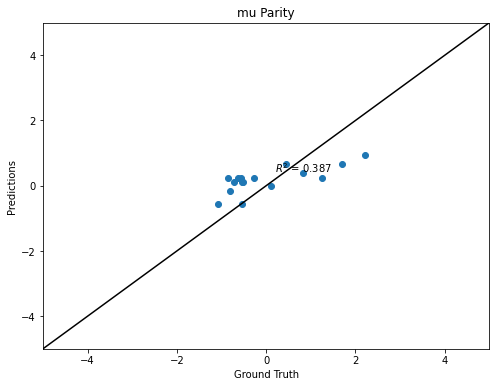

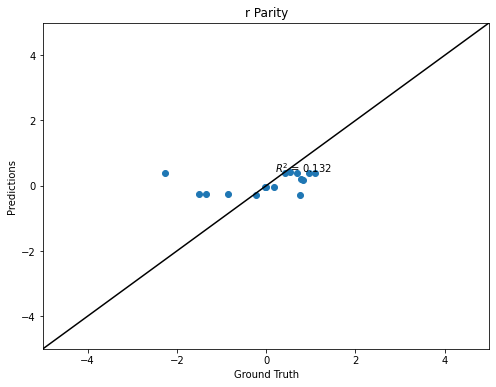

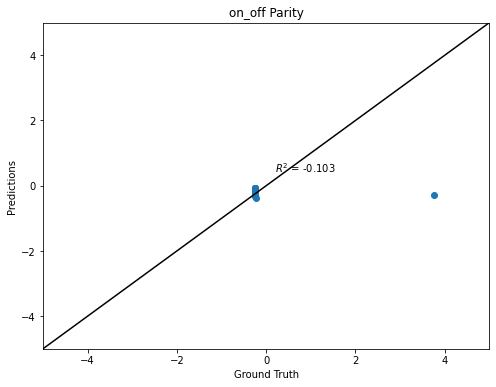

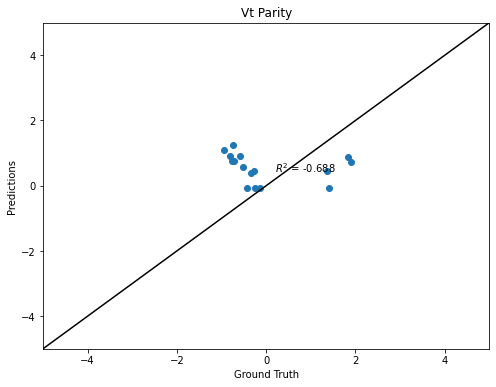

In [11]:
%autoreload
nuts.plot_OFET_parity(mu_labels, mu_out, r_labels, r_out,
                      on_off_labels, on_off_out, vt_labels, vt_out)